    ==============================================================================================

## Importing the DataFrames
- ``` df = pd.read_pickle("file_name.pkl")```  --> create 1 df from a pkl file

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.min_rows", 0) 
pd.set_option("display.max_rows", 30) 
pd.__version__

'1.4.4'

In [32]:
db_qu = pd.read_pickle("clean_Tables\Merged_c.pkl")

In [33]:
db_qu.columns

Index(['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid', 'OL_ID', 'ol_ProdQnty',
       'ol_ProdUntPr', 'ol_ProcessDate', 'PRO_SKU', 'pro_Name', 'pro_Desc',
       'pro_Pr', 'pro_InStock', 'pro_Type'],
      dtype='object')

    ==============================================================================================

## Answer Bussines questions


- Concerns
    A. The main investors pointed out the company’s recent quarterly results showed
        1.  increase in orders placed but a decrease in the total revenue. They prefer that the company positions itself in the quality segment, rather than competing to offer the lowest prices in the market.
    B. Questions
        1. How products should be classified into different categories to simplify reports and analysis.
        2. What is the distribution of product prices across different categories.
        3. How many products are being discounted.
        4. How big are the offered discounts as a percentage of the product prices. --> tmp_dis_per

### Discount Variation with Product Types


#### 4. How big are the offered discounts as a percentage of the product prices.

In [34]:
db_proDis=(
    db_qu
    #.drop(columns=drop_lst_proDis)
    #.reindex(columns=["PRO_SKU","pro_Name","pro_Type","ol_ProdUntPr","pro_Pr"])
    .assign(tmp_pro_dis = db_qu.pro_Pr - db_qu.ol_ProdUntPr)
)

In [35]:
db_proDis= (
    db_proDis
    .assign(tmp_dis_per = np.where((db_proDis.pro_Pr== 0.0)
                                   ,100
                                   ,round((db_proDis.tmp_pro_dis/db_proDis.pro_Pr)*100,2)
                                   ))
    )

In [36]:
# db_proDis.tmp_dis_per.means=''' amount of discount per product, 
# -ve means item sold higher than original price
# 0 means no discount
# 100 means item was sold for free '''

In [37]:
db_proDis.tmp_dis_per.describe()

count    60943.000000
mean        21.267464
std         18.752120
min       -212.270000
25%          8.330000
50%         17.270000
75%         28.290000
max        100.000000
Name: tmp_dis_per, dtype: float64

<AxesSubplot:>

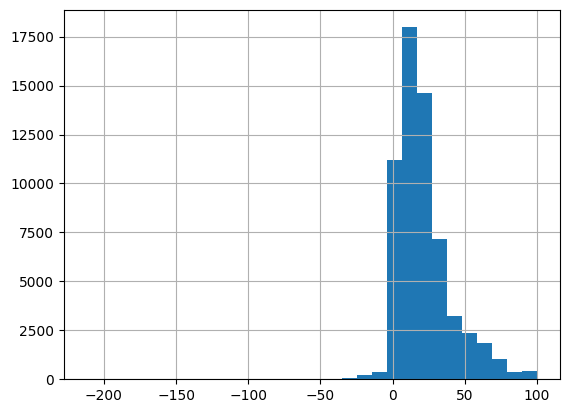

In [38]:
db_proDis.tmp_dis_per.hist(bins=30)

- Remove Outliers

In [39]:
Q1 = db_proDis.tmp_dis_per.quantile(0.25)
Q3 = db_proDis.tmp_dis_per.quantile(0.75)
IQR=Q3-Q1
inliers = (db_proDis.tmp_dis_per >= (Q1 - 1.5*IQR)) & (db_proDis.tmp_dis_per <= (Q3 + 1.5*IQR))
num_inliers = inliers.sum()
num_outliers = db_proDis.shape[0]-num_inliers 
per_outliers = round((num_outliers/db_proDis.shape[0])*100,2)
print(f'''{num_outliers} out of {db_proDis.shape[0]} are outliers from tmp_dis_per ,ie {per_outliers}%''') 

3857 out of 60943 are outliers from tmp_dis_per ,ie 6.33%


In [40]:
db_proDis = db_proDis.loc[inliers]

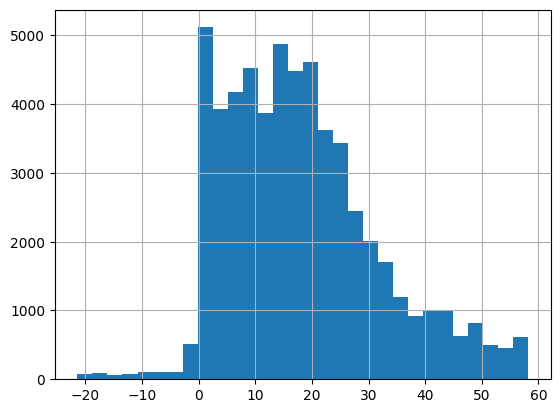

In [41]:
db_proDis.tmp_dis_per.hist(bins=30);

In [42]:
db_proDis.tmp_dis_per.describe()

count    57086.000000
mean        18.101614
std         13.647078
min        -21.410000
25%          7.720000
50%         16.420000
75%         25.590000
max         58.210000
Name: tmp_dis_per, dtype: float64

- Conclusion

In [43]:
print(f"The discounts grows up to {db_proDis.tmp_dis_per.max()}% of the product original price")

The discounts grows up to 58.21% of the product original price


Discounts over time

<AxesSubplot:xlabel='ord_CreatDate,ord_CreatDate'>

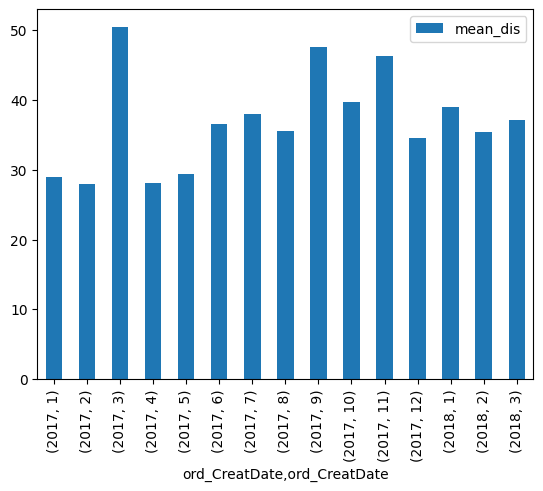

In [44]:
(
    db_proDis
    .groupby([db_proDis.ord_CreatDate.dt.year,db_proDis.ord_CreatDate.dt.month])
    .agg(mean_dis =("tmp_pro_dis","mean"))
    .plot(kind="bar")
    #.sort_values(by="mean_dis"
                 #,ascending=False
                # )
)

### B.1/2 product Categorization (db_proDis)
- Recap:
    - ol_ProdUntPr : the unitary price (euros) of each product at the moment of placing that order
    - pro_Pr       : product price without discounts
- check if rows are unique for sku
- discounts per product --> pro_Pr - ol_ProdUntPr

In [45]:
drop_list=["ORD_ID","ord_TotlPaid","ol_ProdQnty","ord_CreatDate","OL_ID","ol_ProcessDate","pro_InStock"]

In [46]:
#db_proCat = db_qu.drop(columns=drop_list)

##### Category via pro_Type

In [47]:
db_qu.pro_Type.nunique()

123

In [48]:
db_qu.shape

(60943, 13)

In [49]:
import re
def fix_type(row):
    val= row.pro_Type
    if "E" not in val:
        num_len= len(val)
        if num_len < 6:
            return [val,0]
        elif num_len == 8:
            return[val[4:8],val[0:4]]
        elif num_len == 9:
            return[val[5:9],val[0:5]]
    else:
        m = re.search('^(\d+),(\d+)E\+(\d{2})$', val)
        if m:
            return[m.group(1)+m.group(2),0]
        else:
            return[0,0]

In [50]:
db_qu[["tmp_type_1","tmp_type_2"]] = db_qu.apply(fix_type,axis=1,result_type="expand")

In [51]:
db_qu.sample(3)

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_type_1,tmp_type_2
42653,345561,2017-04-12 09:04:29,13.98,1226751,1,9.99,2017-04-12 09:00:00,GRT0315,Griffin Survivor Case All-Terrain iPad mini 1/...,An ultra resistant with 360 degree protection ...,49.99,False,12635403,5403,1263
7647,352765,2017-05-04 17:48:16,158.99,1241725,1,158.99,2017-05-04 17:44:56,KIN0153-2,Mac memory Kingston 16GB (2x8GB) SO-DIMM DDR3å...,RAM 16GB MacBook Pro iMac (2013) and Mac mini ...,149.98,False,1364,1364,0
22685,376487,2017-07-12 17:22:34,410.57,1290939,1,299.00,2017-07-12 17:20:49,LGE0046,"24UD58-B LG Monitor 238 ""4K UHD",238 inch monitor with 2 HDMI ports and a Displ...,349.00,True,1296,1296,0


In [52]:

db_types=round(
    db_qu
    .groupby(db_qu.pro_Type)
    .agg( AvgUnitPrice      =("pro_Pr","mean")
         ,AvgDisUnitPrice   =("ol_ProdUntPr","mean")
         ,NumUniqProducts   =("PRO_SKU",pd.Series.nunique)
         ,NumUniqOrders     =("ORD_ID",pd.Series.nunique)
         ,TotalRevenue      =("ord_TotlPaid","sum")
         ,TotalSoldProdQnty =("ol_ProdQnty","sum")
         ,ProNameSample     =("pro_Name","max")
         ,ProDescSample     =("pro_Desc","max")
         )
    #.nlargest(10,"ol_ProdQnty")
    .reset_index()
)
db_types= (
    db_types
    .assign(AvgDiscoutPercent = np.where((db_types.AvgUnitPrice== 0.0)
                                   ,100
                                   ,round(((db_types.AvgUnitPrice-db_types.AvgDisUnitPrice)/db_types.AvgUnitPrice)*100,2)
                                   ))
    )


In [53]:
db_types.sample(3)

,pro_Type,AvgUnitPrice,AvgDisUnitPrice,NumUniqProducts,NumUniqOrders,TotalRevenue,TotalSoldProdQnty,ProNameSample,ProDescSample,AvgDiscoutPercent
29,1230,23.0,13.0,58,1316,186372.0,2007,elago Lightning Cable 1m Aluminum Space Gray,headphone jack adapter 2 Mini-3-pin mini-jack ...,43.48
71,20642062,461.0,60.0,11,95,37095.0,96,Service installation RAM + HDD + SSD iMac,installation RAM HDD + SSD + on your iMac + Da...,86.98
53,13855401,84.0,73.0,24,923,411737.0,1076,Spanish Keyboard Keyboard Magic Apple Mac (OEM),expansion keypad keys 23 Bluetooth connection ...,13.10


In [54]:
#db_types.to_csv("test.csv")

In [55]:
round(db_types.describe())

,AvgUnitPrice,AvgDisUnitPrice,NumUniqProducts,NumUniqOrders,TotalRevenue,TotalSoldProdQnty,AvgDiscoutPercent
count,123.0,123.0,123.0,123.0,123.0,123.0,123.0
mean,494.0,413.0,48.0,469.0,198368.0,556.0,22.0
std,852.0,769.0,91.0,745.0,343346.0,923.0,17.0
min,6.0,5.0,1.0,1.0,97.0,1.0,-4.0
25%,59.0,41.0,5.0,32.0,9466.0,36.0,10.0
50%,151.0,112.0,20.0,169.0,47478.0,171.0,19.0
75%,542.0,444.0,42.0,657.0,225197.0,706.0,28.0
max,5554.0,5221.0,714.0,4092.0,2050209.0,4848.0,90.0


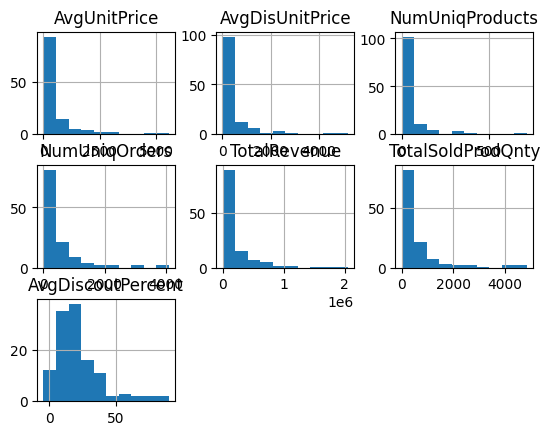

In [56]:
db_types.hist();

- Get Top 10s

In [57]:
db_types.sample(3)

,pro_Type,AvgUnitPrice,AvgDisUnitPrice,NumUniqProducts,NumUniqOrders,TotalRevenue,TotalSoldProdQnty,ProNameSample,ProDescSample,AvgDiscoutPercent
102,51912158,2806.0,2432.0,1,1,2432.0,1,"Open - Apple MacBook Pro 15 ""Core i7 Touch Bar...",MacBook Pro 15-inch Touch Bar refitted with Co...,13.33
39,1280,562.0,458.0,3,11,7480.0,12,Synology RackStation RX415 expansion module,Rackmount Security for Mac mini.,18.51
78,21632158,4771.0,4292.0,14,26,133904.0,29,Apple Mac Pro 8-core 3GHz | 64GB RAM | 256GB P...,New Mac Pro with 64GB of RAM and two 6-core GP...,10.04


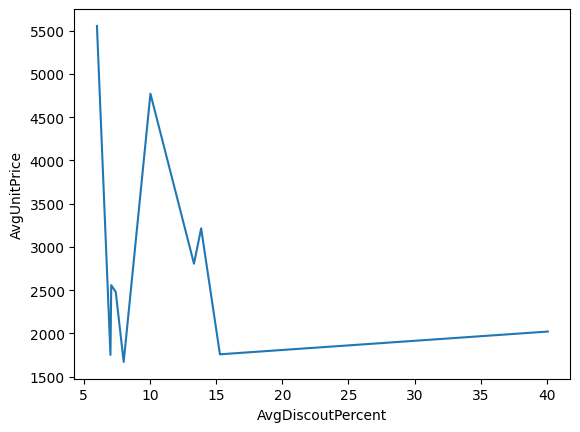

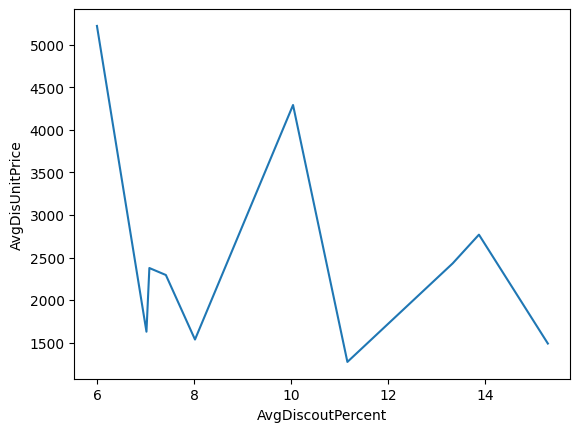

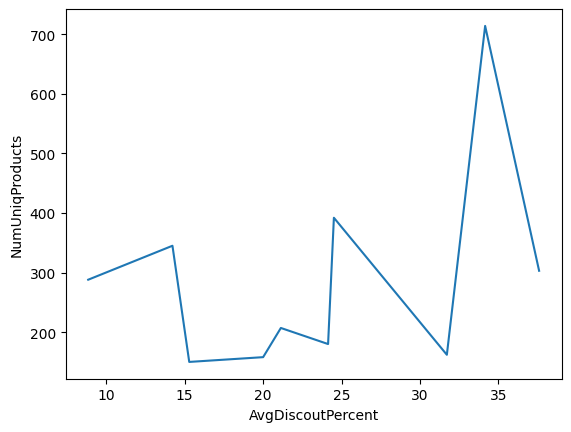

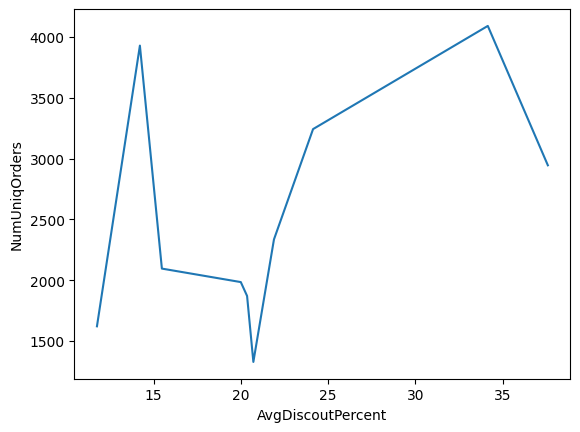

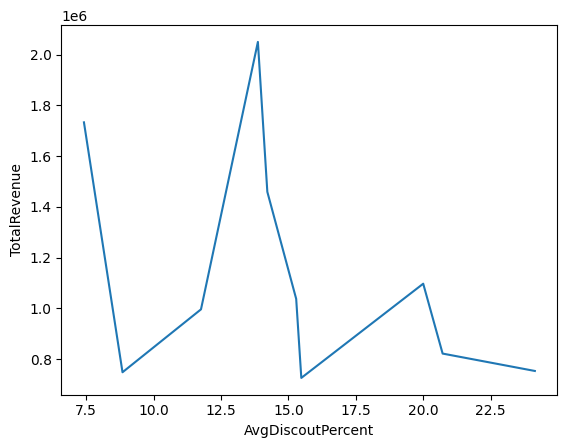

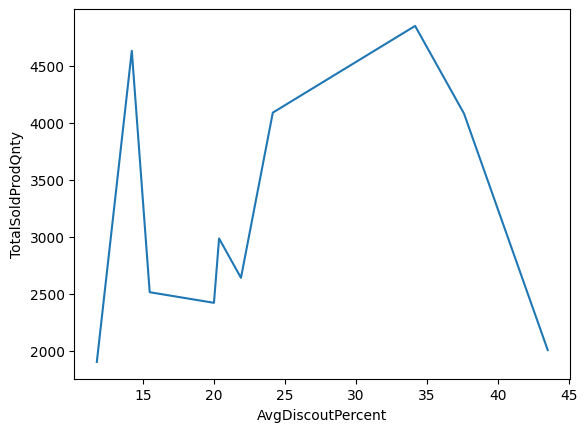

TypeError: Column 'ProNameSample' has dtype object, cannot use method 'nlargest' with this dtype

In [58]:
for col in db_types.columns:
    if (col == "pro_Type"
    or col == "ProNameSample"
    or col == "ProDescSample"):
        continue
    df=db_types.nlargest(10, columns=col)
    sns.lineplot(data=df
                ,x="AvgDiscoutPercent"
                ,y=col)
    plt.show()
    
        


In [ ]:
# g=sns.relplot(data=db_types
#             ,x="AvgUnitPrice"
#             ,y= "AvgDiscoutPercent"
#             )
sns.relplot(data=db_types
            ,kind="line"
            ,x="AvgDiscoutPercent"
            ,y="TotalRevenue"
            #,hue="TotalSoldProdQnty"
            #,style="event",
)


In [ ]:
pd.set_option("display.max_colwidth", 5000) 
db_types.sample(3)

##### Category via pro_Name

In [ ]:
db_proDis.pro_Name.sample(10)

In [ ]:
from collections import Counter
from stop_words import get_stop_words
import nltk
from nltk import corpus

nltk.download('stopwords')
stop_words = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(corpus.stopwords.words('english')) #About 150 stopwords
other_words = [" ",",","?","|","/","-"]
stop_words.extend(nltk_words)
stop_words.extend(other_words)
#print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jacqueline\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

def common_words(row):
    text=row.pro_Name
    split_it = text.split()
    filtered_words = [w for w in split_it if not w in stop_words]
    #print(filtered_words)
    counter = Counter(filtered_words)
    most_occur = counter.most_common(10)
    return(most_occur)

#common_words("Hi baby iam here , where are you ?")

In [ ]:
db_types.loc[2]

In [2]:
(db_qu
 .groupby("pro_Type")
 .apply(common_words,axis=1)
 )

NameError: name 'db_qu' is not defined

In [ ]:
db_types.cat_1.to_csv("test.csv")

In [ ]:
db_types.groupby(db_types.tmp_type_1).describe().pro_Pr.sort_values(by="mean")

__ Category via pro_Pr

In [ ]:
db_qu.pro_Pr.describe()

In [ ]:
def Price_cat (price):
    if price < 50:
        return "A"
    elif price < 200:
        return "B"
    elif price < 1000:
        return "C"
    elif price < 5000:
        return "D"
    elif price >= 5000:
        return "E"


In [ ]:
db_proDis["tmp_pr_cat"] = db_proDis.pro_Pr.map(Price_cat)

In [ ]:
(
    db_proDis
    .groupby("tmp_pr_cat")
    .agg(price_cat_num=("tmp_pr_cat","count"))
)

In [ ]:
pd.set_option('max_colwidth', 100)

In [ ]:
db_proDis.loc[db_proDis.tmp_pr_cat == "A"].drop(columns=drop_list).sample(5)

In [ ]:
db_proDis.loc[db_proDis.pro_Name.str.contains("(imac)", case=False, regex=True)].drop(columns=drop_list)

In [ ]:
pattern = '|'.join(["watch"])

In [ ]:
pattern = '|'.join(["watch"])
db_proDis.loc[db_proDis.pro_Name.str.contains(pattern, case=False, regex=True)].drop(columns=drop_list).sample(10)

In [ ]:
db_proDis.sample(5)